In [2]:
import ujson as json
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sklearn.cluster as clstr
import scipy.sparse as sp
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
import seaborn as sb
import pandas as pd
import itertools

In [4]:
type_1_files = ['2_train.json', '2_test.json', '1_test.json', '1_train.json']
type_2_files = ['Apsaras3.json', '2_test_2.json']
positions = []
grottoes = []
files = []
ARTIC_NAMES = {'foot 1': 0,
               'foot 2': 1,
               'knee 1': 2,
               'knee 2': 3,
               'belly': 4,
               'elbow 1': 5,
               'elbow 2': 6,
               'hand 1': 7,
               'hand 2': 8,
               'eye 1': 9,
               'eye 2': 10,
               'shoulder 1': 11,
               'shoulder 2': 12}
for f in type_1_files: 
    file = open(f)
    data = json.load(file)
    for i in range(0,len(data)):
        apsara = data[i]
        files.append(apsara['apsaras']['file'])
        grottoes.append(apsara['apsaras']['grottoe'])
        access = apsara['apsaras']['positions']
        position = []
        for articulation in ARTIC_NAMES.keys():
            position.append(access[articulation])
        positions.append(position)

for f in type_2_files: 
    file = open(f)
    data = json.load(file) 
    for apsara in data['apsaras']:
        grottoes.append(apsara['grottoe'])
        files.append(apsara['file'])
        access = apsara['positions']
        position = []
        for articulation in ARTIC_NAMES.keys():
            position.append(access[articulation])
        positions.append(position)
        
positions = np.array(positions)

In [5]:
positions.shape

(557, 13, 2)

In [63]:
def plot_line(apsara, a1, a2, ax, c='black'):
    """
    Plot the leg/arm/... between articulations a1 and a2
    """
    i1 = ARTIC_NAMES[a1]
    i2 = ARTIC_NAMES[a2]
    ax.plot(apsara[(i1, i2), 0], apsara[(i1, i2), 1], c)
def plot_pose(apsara, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    plot_line(apsara, 'foot 1', 'knee 1', ax)
    plot_line(apsara, 'knee 1', 'belly', ax)
    plot_line(apsara, 'foot 2', 'knee 2', ax)
    plot_line(apsara, 'knee 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'belly', ax)
    plot_line(apsara, 'shoulder 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'elbow 1', ax)
    plot_line(apsara, 'shoulder 2', 'elbow 2', ax)
    plot_line(apsara, 'elbow 1', 'hand 1', ax)
    plot_line(apsara, 'elbow 2', 'hand 2', ax)
    plot_line(apsara, 'shoulder 1', 'shoulder 2', ax)
    plot_line(apsara, 'eye 1', 'eye 2', ax)

def plot_all(apsaras, line_length=12):
    fig, ax = plt.subplots()
    for i, apsara in enumerate(apsaras):
        plot_pose(apsara + 5*np.array([[i%line_length, i//line_length]]), ax=ax)

In [64]:
def preprocess(data):    
    data = 1.*np.delete(data, np.all(np.all(data==-1, axis=1), axis=1), axis=0)
    data[data==-1] = np.nan
    norm_data = (data - np.nanmean(data, axis=1)[:, None, :]) / np.nanstd(data, axis=1, ddof=1)[:, None, :]
    return -norm_data

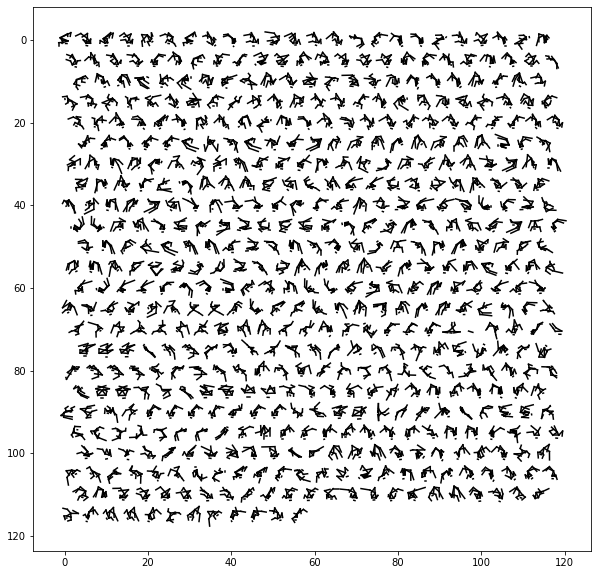

In [66]:
plot_all(preprocess(positions), np.sqrt(positions.shape[0]))
plt.savefig("output.png")

In [67]:
def remove_nans(data):
    return np.delete(data, 
                     np.any(np.any(np.isnan(data),
                                   axis=1),
                            axis=1),
                     axis=0)
def prepare_kmeans(data, n_clusters):
    data = remove_nans(preprocess(data))
    flat_data = data.reshape(data.shape[0], -1)
    kmeans = clstr.KMeans(n_clusters=n_clusters).fit(flat_data)
    return kmeans

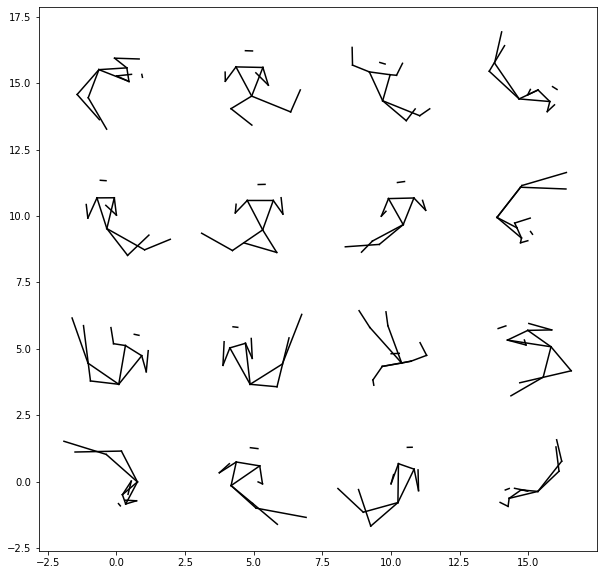

In [68]:
km = prepare_kmeans(positions, 16)
centers = km.cluster_centers_
plot_all(centers.reshape(centers.shape[0], -1, 2), line_length=4)

# Temporal analysis

In [7]:
df = pd.DataFrame(positions.reshape(positions.shape[0],-1), columns= pd.MultiIndex.from_product([ARTIC_NAMES.keys(),['x','y']]))

In [10]:
df['file'] = files

In [40]:
def preprocess(data):    
    data = data.replace(-1, None)
    norm = data.copy()
    
    x_mean_per_row = df.iloc[:, :-1].groupby(axis=1,level=1).mean()['x']
    x_std_per_row = df.iloc[:, :-1].groupby(axis=1,level=1).std()['x']
    
    norm.iloc[:,norm.columns.get_level_values(1)=='x'] = df.xs('x',axis = 1, level=1).transform(lambda x : (x-x_mean_per_row) / x_std_per_row)
    
    y_mean_per_row = df.iloc[:, :-1].groupby(axis=1,level=1).mean()['y']
    y_std_per_row = df.iloc[:, :-1].groupby(axis=1,level=1).std()['y']
    norm.iloc[:,norm.columns.get_level_values(1)=='y'] = df.xs('y',axis = 1, level=1).transform(lambda y : (y-y_mean_per_row) / y_std_per_row)
    return norm

In [45]:
norm = preprocess(df)

In [163]:
def plot_line(apsara, a1, a2, ax, c='black'):
    """
    Plot the leg/arm/... between articulations a1 and a2
    """
    i1 = ARTIC_NAMES[a1]
    i2 = ARTIC_NAMES[a2]
    ax.plot([apsara[a1]['x'],apsara[a2]['x']],[apsara[a1]['y'],apsara[a2]['y']], c)
def plot_pose(apsara, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    plot_line(apsara, 'foot 1', 'knee 1', ax)
    plot_line(apsara, 'knee 1', 'belly', ax)
    plot_line(apsara, 'foot 2', 'knee 2', ax)
    plot_line(apsara, 'knee 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'belly', ax)
    plot_line(apsara, 'shoulder 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'elbow 1', ax)
    plot_line(apsara, 'shoulder 2', 'elbow 2', ax)
    plot_line(apsara, 'elbow 1', 'hand 1', ax)
    plot_line(apsara, 'elbow 2', 'hand 2', ax)
    plot_line(apsara, 'shoulder 1', 'shoulder 2', ax)
    plot_line(apsara, 'eye 1', 'eye 2', ax)
    
def plot_all(apsaras, line_length=12):
    copied = apsaras.copy()
    fig, ax = plt.subplots()
    for i, apsara in copied.iterrows():
        plot_pose(apsara[ARTIC_NAMES] + 5* np.tile([i%line_length, i//line_length], 13) , ax=ax)

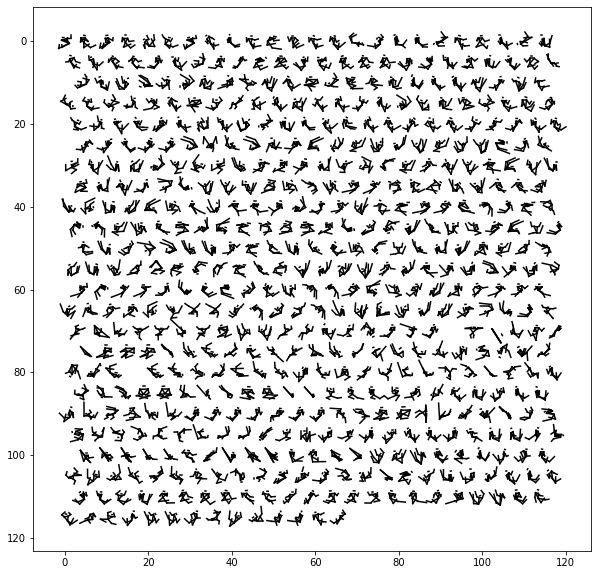

In [164]:
plot_all(norm, np.sqrt(norm.shape[0]))